In [ ]:
!pip install yfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cd drive/MyDrive/Seminar
!pwd

/content


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import yfinance as yf
from datetime import date, timedelta

In [ ]:
start_date = '2015-01-01'
end_date = '2021-11-30'

ticker = "SBIN.NS"
df = yf.download(ticker, start_date, end_date)
filename = "drive/MyDrive/Seminar/"+ticker+".csv"
df.to_csv(filename)
df.shape

[*********************100%***********************]  1 of 1 completed


(1704, 6)

In [ ]:
df = pd.read_csv(filename)
print(df.tail(10)) #7 columns, including the Date.

In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

#Variables for training
cols = list(df)[1:6]

#New dataframe with only training data - 5 columns
df_data = df[cols].astype(float)
df_data.shape

(1704, 5)

In [ ]:
#split the data in train and test
train_len = int(len(df_data)*0.8)
test_len = len(df_data) - train_len

df_for_testing = df_data[train_len:]
df_for_training = df_data[0:train_len]


In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler = scaler.fit(df_for_testing)
df_for_testing_scaled = scaler.transform(df_for_testing)

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []
testX = []
testY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

print('trainX shape == {}.'.format(testX.shape))
print('trainY shape == {}.'.format(testY.shape))


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(16))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 39,201
Trainable params: 39,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=25, batch_size=16,verbose=1, validation_split=0.2)



Epoch 1/25
68/68 [==============================] - 15s 150ms/step - loss: 0.1673 - accuracy: 0.0000e+00 - val_loss: 0.3152 - val_accuracy: 0.0000e+00
Epoch 2/25
68/68 [==============================] - 10s 143ms/step - loss: 0.0664 - accuracy: 0.0000e+00 - val_loss: 0.1241 - val_accuracy: 0.0000e+00
Epoch 3/25
68/68 [==============================] - 10s 144ms/step - loss: 0.0526 - accuracy: 0.0000e+00 - val_loss: 0.1008 - val_accuracy: 0.0000e+00
Epoch 4/25
68/68 [==============================] - 10s 143ms/step - loss: 0.0351 - accuracy: 0.0000e+00 - val_loss: 0.0641 - val_accuracy: 0.0000e+00
Epoch 5/25
68/68 [==============================] - 10s 140ms/step - loss: 0.0285 - accuracy: 0.0000e+00 - val_loss: 0.0497 - val_accuracy: 0.0000e+00
Epoch 6/25
68/68 [==============================] - 9s 138ms/step - loss: 0.0181 - accuracy: 0.0000e+00 - val_loss: 0.0327 - val_accuracy: 0.0000e+00
Epoch 7/25
68/68 [==============================] - 10s 142ms/step - loss: 0.0132 - accuracy: 0

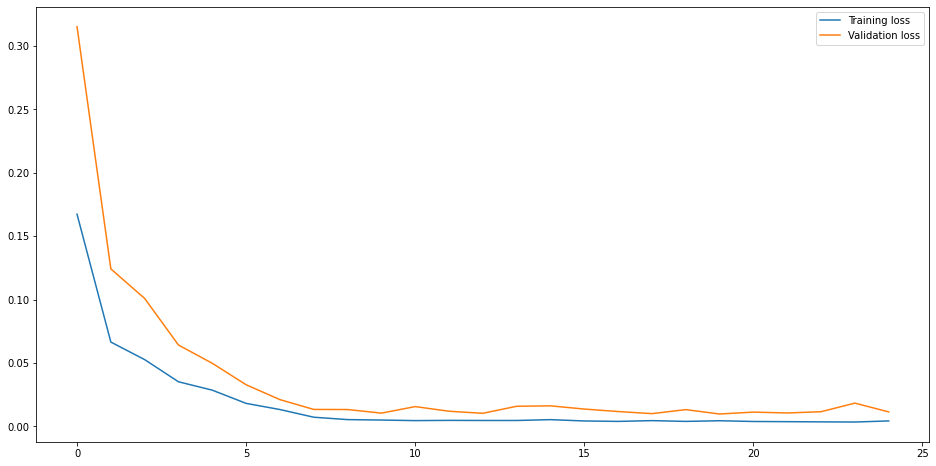

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#save the model
model.save("drive/MyDrive/Seminar/"+ticker+".h5")

In [47]:
#Make prediction
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


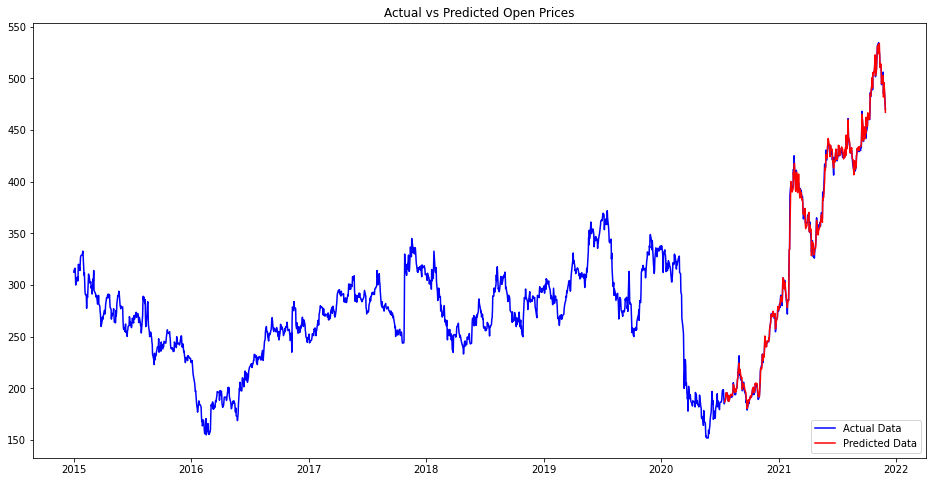

In [48]:
#plot the original and predicted data
trained_data = df[:train_len]

actual_data = pd.DataFrame({"Dates": np.array(df["Date"]), "Open":df["Open"]})
actual_data["Dates"] = pd.to_datetime(actual_data["Dates"])

dates = train_dates[-test_len:]
joined = df["Open"][train_len:train_len+14]
joined = joined.to_numpy()
joined = np.append(joined, y_pred_future)

pred_data = pd.DataFrame({"Dates":np.array(dates), "Open":joined})
pred_data["Dates"] = pd.to_datetime(pred_data["Dates"])

plt.figure(figsize=(16,8))
plt.plot(actual_data["Dates"], actual_data["Open"], label="Actual Data", color='b')
plt.plot(pred_data["Dates"], pred_data["Open"], label="Predicted Data", color='r')
plt.title("Actual vs Predicted Open Prices")
plt.legend(loc='lower right')

In [49]:
#Performance evualation for prediction

#print("MAPE: ",mean_absolute_percentage_error(df[-test_len:]["Open"], joined)*100,"%")
print("MAE: ",mean_absolute_error(df[-test_len:]["Open"], joined))
print("RMSE: ",mean_squared_error(df[-test_len:]["Open"], joined))

MAE:  2.22721133413902
RMSE:  12.062140497519653
